We want to explore how frequency is defined for xrft. Frequency $f$ is calculated based off np.fft.fftfreq. Specifically,

$f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)$,  if $n$ even\
$f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)$,  if $n$ is odd

This means that we've been calculating frequency with units $degrees^{-1}$. We want to find frequency with units $km^{-1}$, since the distance corresponding with one degree is different at different locations on Earth.

In [10]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import gcm_filters
import xrft

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data
from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

In [43]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

Latitude and longitude can be converted from units of degrees to km as follows\
    $lat_{km} = lat_{deg} * 111.32 km$ \
    $lon_{km} = lon_{deg} * 111.32 km * cos(rad(lat_{deg}))$ \
\
We use the approximation \
    $lon_{km} = lon_{deg} * 111.32 km$\
for simplicity, since longitude values are dependent on latitude values. We want to have a longitude that's independent of latitude in order to troubleshoot the below approach. If we use the more precise approximation, we end up with a grid of x- and y- kilometer values. \
\
Question: How should we proceed with this degree --> km conversion? Should we center the lat/lon ranges somehow?

In [44]:
# Example arrays of latitudes and longitudes in degrees
latitudes = ds_merged.yt_ocean  # in degrees
longitudes =  ds_merged.xt_ocean + 100 # in degrees

# Radius of Earth in kilometers (mean radius)
R = 6371  # kilometers

# Convert latitude to kilometers (distance per degree of latitude is constant)
latitude_in_km = latitudes * 111.32  # in kilometers

# Convert longitude to kilometers (distance per degree of longitude varies with latitude)
longitude_in_km = longitudes * 111.32 # * np.cos(np.radians(latitudes))  # in kilometers

In [45]:
ds_merged['yt_ocean'] = latitude_in_km
ds_merged['xt_ocean'] = longitude_in_km
ds_merged

<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -2.003e+04 -2.002e+04 ... 2.003e+04
  * yt_ocean      (yt_ocean) float64 22kB -9.029e+03 -9.024e+03 ... 1.002e+04
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [46]:
ds_in = ds_merged
ds_in = ds_in.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
ds_in

<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -2.003e+04 -2.002e+04 ... 2.003e+04
  * yt_ocean      (yt_ocean) float64 22kB -9.029e+03 -9.024e+03 ... 1.002e+04
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [47]:
print("Filtering model")
ds_out_50 = filter_inputs_dataset(ds_in, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
ds_out_50

Filtering model


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -2.003e+04 -2.002e+04 ... 2.003e+04
  * yt_ocean      (yt_ocean) float64 22kB -9.029e+03 -9.024e+03 ... 1.002e+04
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

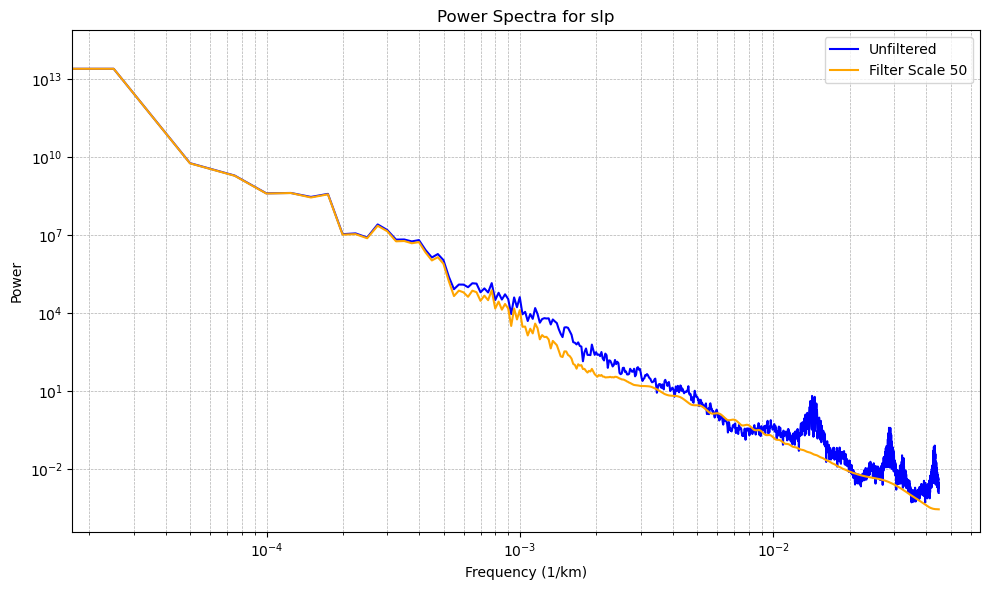

In [61]:
# Define the variable to plot
var = "slp"  # Replace with the name of the variable you want to plot

# Create a figure for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Extract high-res data for the variable and compute means
high_res = ds_in[var][0]
ds_out_50_avg = ds_out_50[var][0]

# Compute power spectra
# (average over yt_ocean, since the yt_ocean points are not evenly spaced, but the xt_ocean points are)
ps_orig = xrft.power_spectrum(high_res, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps_50 = xrft.power_spectrum(ds_out_50_avg, dim='xt_ocean', window=True).mean(dim='yt_ocean')

# Plot power spectra
ax.plot(ps_orig.freq_xt_ocean, ps_orig, label='Unfiltered', color='blue')
ax.plot(ps_50.freq_xt_ocean, ps_50, label='Filter Scale 50', color='orange')

# Configure plot
ax.set_title(f"Power Spectra for {var}")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (1/km)')
ax.set_ylabel('Power')
ax.legend(loc='best')
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the figure
plt.tight_layout()
plt.show()


As we can see, the power spectra has been calculated. However, it looks like for smaller scales, the power spectra doesn't simply drop off. Instead, it simply smooths out behavior at lower scales. What should our next step be?